This script intends to provide a quick and basic example of a credit analysis framework. We will be exploring a dataset from ICE indices (C0A0) that represents US Investment Grade Corporate Credit. Our intent is to identify bonds in the Tech industry with a BBB-B rating that have strong credit quality and trade at an attractive level. ICE data was collected on 7/29/2023 and company financials are downloaded upon executing this code.

The credit quality evaluation will utilize the Altman Z-score, a common framework that has been popularized in academia. The analysis of value will be conducted using the Nelson-Siegel model to fit a curve to the OAS of all bonds within the desired sample. From there, we will calculate the residual of each bond to the implied OAS generated from the fitted curve and will average each issuer's distance to the curve. This value will represent the average value embedded into the bonds of the issuer.

In [3]:
import pandas as pd
df = pd.read_excel('C:/Users/dstoc/Documents/Python Scripts/First Project/ICE Agg.xlsx')
df2 = df.copy()

df2 = df2.iloc[0:len(df2),]

Define a few functions to convert the maturity dates to a numeric value and then another to apply the custom valuation methodology.

In [4]:
from datetime import datetime, timedelta

# Define the date format
date_format = "%Y-%m-%dT%H:%M:%S.%f"

# Define a function to convert a date string to the number of days away
def convert_to_years(date_str):
    #date_obj = datetime.strptime(date_str, date_format)
    date_obj = date_str#.strftime("%Y-%m-%d")
    current_date = datetime.now()
    years_away = (date_obj - current_date).days / 365

    if years_away < 0:
        years_away = years_away + 100  # Add 100 years (365.25 days per year on average)
    
    return years_away

# Apply the function to the 'Date' column
df2['MaturityYears'] = df2['Maturity Date'].apply(convert_to_years)


In [5]:
import numpy as np
from nelson_siegel_svensson.calibrate import calibrate_ns_ols, errorfn_ns_ols
from matplotlib import pyplot as plt

def my_NS_func(x_df):
    time = np.array(x_df["MaturityYears"])
    yld = np.array(x_df["OAS"])


    curve, status = calibrate_ns_ols(
        time,yld, tau0= 0.10
    )  
    assert status.success
    curve  

    Yhat = x_df['OAS'].apply(curve)
    x_df.loc[:,'Yhat'] = Yhat

    Spread_to_Curve = x_df['OAS'] - x_df['Yhat']
    return Spread_to_Curve

In [6]:
df3 = df2.copy()
df3['OAS'] = df3['OAS'].astype(float)
df3 = df3.dropna(subset='OAS')
df3 = df3[df3['Industry Lvl 3 Code'] == 'Tech']
df3 = df3[df3['Rating'].isin(['BBB1','BBB2','BBB3'])]

In [7]:
df3['OAS'].isna().any()

False

Plot the term structure of the desired industry.

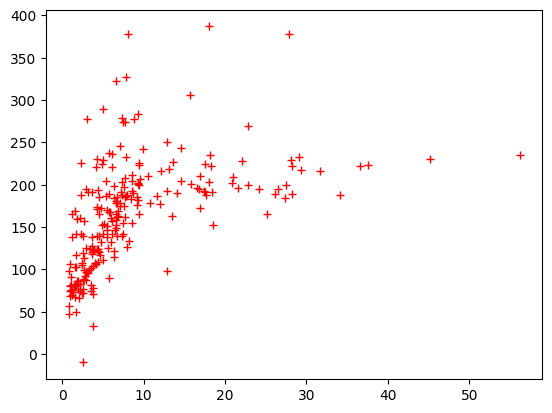

In [8]:
time = np.array(df3["MaturityYears"])
yld = np.array(df3["OAS"])
plt.plot(time,yld, "r+"); 


Fit a Nelson-Siegel Model to the data

In [9]:
curve, status = calibrate_ns_ols(
    time,yld, tau0=0.1
)  
assert status.success
curve  

NelsonSiegelCurve(beta0=240.15192500031537, beta1=-114.437938579881, beta2=-311.5963085431315, tau=0.959893174619085)

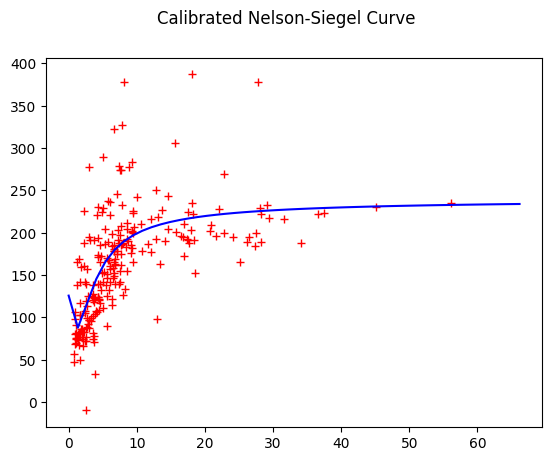

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.suptitle("Calibrated Nelson-Siegel Curve")
ax.plot(time, yld, "r+")
t2 = np.linspace(0, df3['MaturityYears'].max() +10 )
ax.plot(t2, curve(t2), "b-");

Generate implied OAS values from the model and calculate residuals. Since we are only using one sector, the function we defined earlier is not necessary.

In [11]:
df3['Yhat'] = df3['MaturityYears'].apply(curve)
df3['Spread to Curve'] = df3['OAS'] - df3['Yhat']

Copy the dataframe and average the residuals by each issuer

In [12]:
df4 = df3.copy()
df4['Issuer Avg Spread to Curve'] = df4.groupby('Ticker')['Spread to Curve'].transform('mean')

We now proceed to evaluating the credit quality of our companies. This will be done using Yahoo Finance as it is freely available data. Unfortunately, not every issuer has data available so our pool shrinks a bit.

In [13]:
import yfinance as yf
import pandas as pd

Define and apply functions to pull data and calcualte desired metrics

In [14]:
def get_financial_ratios(ticker):
    # Get financial data using yfinance
    company = yf.Ticker(ticker)
    financials = company.quarterly_financials
    bal_sht = company.quarterly_balance_sheet
    inc_stmt = company.quarterly_income_stmt
    cash_flw_stmt = company.quarterly_cash_flow

    # Calculate relevant financial ratios
    debt_to_equity = bal_sht.loc["Total Debt"][0] / bal_sht.loc["Stockholders Equity"][0]
    interest_coverage = inc_stmt.loc["Operating Income"][0] / inc_stmt.loc["Interest Expense"][0]

    # Altman Z-score components
    working_capital = bal_sht.loc["Current Assets"][0] - bal_sht.loc["Current Liabilities"][0]
    retained_earnings = bal_sht.loc["Retained Earnings"][0]
    EBIT = inc_stmt.loc["Total Operating Income As Reported"][0]
    total_assets = bal_sht.loc["Total Assets"][0]
    total_equity = bal_sht.loc["Stockholders Equity"][0]
    total_liabilities = total_assets - total_equity

    z_score = 1.2 * (working_capital / total_assets) + 1.4 * (retained_earnings / total_assets) + \
               3.3 * (EBIT / total_assets) + 0.6 * (total_equity / total_assets) + 1.0 * (total_liabilities / total_assets)

    # Create a dictionary with the results
    ratios = {
        "Debt-to-Equity Ratio": debt_to_equity,
        "Interest Coverage Ratio": interest_coverage,
        "Altman Z-Score": z_score,
    }

    return ratios


In [15]:
def evaluate_companies(tickers):
    results = []
    for ticker in tickers:
        try:
            ratios = get_financial_ratios(ticker)
            results.append(pd.DataFrame([ratios], index=[ticker]))
        except Exception as e:
            print(f"Error evaluating {ticker}: {e}")

    # Merge all dataframes into a single dataframe
    merged_df = pd.concat(results)
    return merged_df


In [16]:

if __name__ == "__main__":
    # List of company tickers you want to evaluate
    #company_tickers = ["AAPL", "MSFT", "GOOGL", "META", "ORCL"]
    company_tickers = df4['Ticker'].unique()

    # Evaluate companies and get the results as a dataframe
    credit_quality_df = evaluate_companies(company_tickers)
    print(credit_quality_df)


Error evaluating DXC: 'Total Operating Income As Reported'
Error evaluating GIBACN: 'Total Debt'
Error evaluating HYUELE: 'Total Debt'
Error evaluating KD: 'Total Operating Income As Reported'
Error evaluating LENOVO: 'Total Debt'
Error evaluating LWSN: 'Total Debt'
Error evaluating MOLX: 'Total Debt'
Error evaluating NECELE: 'Total Debt'
Error evaluating NOKIA: 'Total Debt'
Error evaluating OTEXCN: 'Total Debt'
Error evaluating SUMDIG: 'Total Debt'
Error evaluating XIAOMI: 'Total Debt'
      Debt-to-Equity Ratio  Interest Coverage Ratio  Altman Z-Score
ADSK              2.209784                      NaN        0.576106
APH               0.574843                17.825714        1.707895
AVGO              1.781829                10.019704        1.261583
BAH               3.066981                 6.166461        1.572781
DELL             -9.790043                      NaN             NaN
DOX               0.220882                      NaN        2.390197
FLEX              0.760081      

In [17]:
credit_quality_df.reset_index(inplace=True)
credit_quality_df = credit_quality_df.rename(columns = {'index':'Ticker'})

In [18]:
credit_quality_df2 = credit_quality_df.copy()
credit_quality_df2 = credit_quality_df2.iloc[:,0:4]

Gather the valuation for each of the remaining companies and add it to the dataframe

In [19]:
credit_quality_df2["Issuer Avg Spread to Curve"] = np.nan

In [20]:
for ticker in credit_quality_df2['Ticker']:
    temp_df = df4[df4['Ticker'] == ticker]
    credit_quality_df2.loc[credit_quality_df2['Ticker'] == ticker, 'Issuer Avg Spread to Curve'] = temp_df['Issuer Avg Spread to Curve'].iloc[0]

Next, we utilize Dash to generate a nice looking application that allows us to inspect the results in an interactive scatter plot. This may not render when viewed on github so I will add a simple plot below it.

In [21]:
import pandas as pd
import dash
from dash import dcc
from dash import html


In [22]:
# Create a Dash web application
app = dash.Dash(__name__)

# Define the layout of the application
app.layout = html.Div([
    html.H1("Credit Quality Data Visualization"),
    
    # Dropdown for selecting x-axis column
    dcc.Dropdown(
        id='x-axis-dropdown',
        options=[{'label': col, 'value': col} for col in credit_quality_df2.columns],
        value='Debt-to-Equity Ratio'  # Default value for x-axis
    ),

    # Dropdown for selecting y-axis column
    dcc.Dropdown(
        id='y-axis-dropdown',
        options=[{'label': col, 'value': col} for col in credit_quality_df.columns],
        value='Altman Z-Score'  # Default value for y-axis
    ),

    # Graph component for displaying the interactive chart
    dcc.Graph(id='credit-quality-chart')
])

# Define callback to update the chart based on user selections
@app.callback(
    dash.dependencies.Output('credit-quality-chart', 'figure'),
    [dash.dependencies.Input('x-axis-dropdown', 'value'),
     dash.dependencies.Input('y-axis-dropdown', 'value')]
)
def update_chart(x_axis_column, y_axis_column):
    # Create a scatter plot with the selected columns as x and y axes
    figure = {
        'data': [{
            'x': credit_quality_df2[x_axis_column],
            'y': credit_quality_df2[y_axis_column],
            'mode': 'markers',
            'type': 'scatter',
            'text': credit_quality_df2.Ticker,
            'marker': {'size': 12}
        }],
        'layout': {
            'title': f'{y_axis_column} vs. {x_axis_column}',
            'xaxis': {'title': x_axis_column},
            'yaxis': {'title': y_axis_column}
        }
    }
    return figure


In [23]:
# Run the application
if __name__ == '__main__':
    app.run_server(debug=True)

Interpretation of Altman Z-Score:

Z-Score > 2.99: Safe Zone 
    - The company is considered safe, and the likelihood of bankruptcy is low.

1.8 < Z-Score < 2.99: Grey Zone 
    - The company is in a borderline financial situation, and caution is required.

Z-Score < 1.8: Distress Zone 
    - The company is at higher risk of bankruptcy, indicating financial distress.

OAS minus the fitted value from the Nelson-Siegel curve.
    - Positive value indicates that the bond trades wider than anticipated.
    - the average of each issuer is used to approximate average value

<Axes: xlabel='Issuer Avg Spread to Curve', ylabel='Altman Z-Score'>

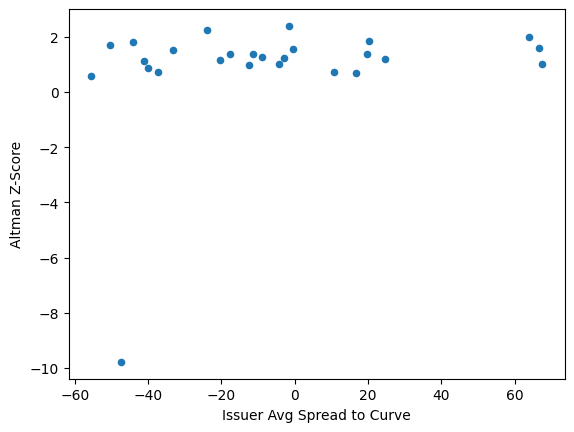

In [24]:
credit_quality_df2.plot.scatter(x='Issuer Avg Spread to Curve', y ='Altman Z-Score')

### My official recommendation would be to overweight the bonds of SWKS, BAH, and MU as they offer an attractive average spread to peers and solid fundamentals.


In [28]:
from itables import init_notebook_mode
init_notebook_mode(connected=True)

# Step 2: Create a DataFrame with sample data
data = credit_quality_df2.copy()
df = pd.DataFrame(data)

df


,Ticker,Debt-to-Equity Ratio,Interest Coverage Ratio,Altman Z-Score,Issuer Avg Spread to Curve
0,ADSK,2.209784,NaN,0.576106,-55.572632
1,APH,0.574843,17.825714,1.707895,-50.542911
2,AVGO,1.781829,10.019704,1.261583,-9.044021
3,BAH,3.066981,6.166461,1.572781,66.598126
4,DELL,-9.790043,NaN,NaN,-5.172109
5,DOX,0.220882,NaN,2.390197,-1.664600
6,FLEX,0.760081,6.319149,1.198543,24.509414
7,FTNT,3.086239,53.653846,1.133562,-41.260691
8,GLW,0.668069,3.444444,1.800381,-44.198503
9,HPE,0.647464,12.060000,0.717829,-37.434794
